# xyt Train & Test Data Preparation

Point Cloud NN requires data in the following scheme:

dataset

--- class1  

    --- train  
        * file.off
        * file.off
    
    --- test 
        * file.off
        * file.off
    

--- class2  

    --- train 
        * file.off
        * file.off
    
    --- test  
        * file.off
        * file.off

In [2]:
def read_csv(READ_PATH):
    """
    Read CSV at specified Path
    """
    return pd.read_csv(READ_PATH)


def identify_groups(df):
    """
    1. Tag groups that have only noise [0]
    2. Tag groups that have both noise and hits [0,1]
    3. Separate noise groups and hits+noise groups
    """
    # Label groups by noise and and hits
    df_count_label_type = pd.DataFrame(df.groupby('group')['label'].unique()).reset_index()
    
    # Obtain groups with only hits
    df_noise = df_count_label_type.loc[
        np.array(list(map(len, df_count_label_type.label.values))) == 1]
    
    # Obtain groups with noise && hits
    df_mixed = df_count_label_type.loc[
        np.array(list(map(len, df_count_label_type.label.values))) > 1]
    
    return df_noise, df_mixed


def generate_dfs(df, df_noise, df_mixed):
    """
    Obtain full dataframe based on identified noise
    only groups and mixed groups
    """
    df_noise = df[df.group.isin(df_noise.group)]
    df_mixed = df[df.group.isin(df_mixed.group)]
    
    return df_noise, df_mixed


def print_df_stats(df_noise, df_mixed):
    """
    General Stats on mixed and noise groups
    """
    noise_stats = df_noise.groupby('group')['label']\
                    .count()\
                    .sort_values(ascending=False)\
                    .describe()
    mixed_stats = df_mixed.groupby('group')['label']\
                    .count()\
                    .sort_values(ascending=False)\
                    .describe()
    
    neg, pos = np.bincount(df_mixed['label'])
    total = neg + pos
    
    hits = df_mixed[df_mixed.label == 1].groupby(['group', 'label'])['label']
    noise = df_mixed[df_mixed.label == 0].groupby(['group', 'label'])['label']
    
    hits_count = hits.count().sort_values(ascending=False)
    noise_count = noise.count().sort_values(ascending=False)
    
    hits_to_noise = hits_count.droplevel(level='label')/noise_count.droplevel(level='label')
    
    class_imbalance = df_mixed.groupby(['group', 'label'])['label'].count()[:20]
    
        
    print("NOISE STATS: \n{}\n".format(noise_stats))
    print("MIXED STATS: \n{}\n".format(mixed_stats))
    
    print("Mixed Groups: \n")
    print("Examples:\n Total: {}\n Positive: {} ({:.2f}% of total)\n".format(total,
                                                                             pos, 100 * pos / total))
    
    print("Example of class imbalance in mixed groups: \n ".format(class_imbalance.head()))
           
    print("Hits Only (Within mixed groups):\n")
    print("The largest hits for a group: {}\n".format(hits_count.max()))
    print("The smallest hits for a group: {}\n".format(hits_count.min()))
    print("The mean hits for a group: {}\n".format(hits_count.mean()))
                                                                                                                                    
    print("Noise Only (Within mixed groups):\n") 
    print("The largest noise for a group: {}\n".format(noise_count.max()))
    print("The smallest noise for a group: {}\n".format(noise_count.min())) 
    print("The mean noise for a group: {}\n".format(noise_count.mean()))
    print("Hits-Noise Ratio:\n") 
    print("The highest ratio: {:.2f}% ({})\n".format(hits_to_noise.max()*100,
                                                    hits_to_noise.max()))
    print("The smallest ratio: {:.2f}% ({}) \n".format(hits_to_noise.min()*100,
                                                       hits_to_noise.min())) 
    print("The mean ratio: {:.2f}% ({})\n".format(hits_to_noise.mean()*100, 
                                                  hits_to_noise.mean())) 

def sort_mixed_groups(df):
    """
    Within each mixed groups (hits + noise), we need to sort
    groups such that those with highest hits are selected first
    
    DataFrame --> List(int)
    """
    
    # group by groups and labels and associated counts for each label
    grouped_df = pd.DataFrame(df.groupby(['group', 'label'])['label'].count())
    grouped_df = grouped_df.rename(columns={'label':'count'})
    
    # sort groups based on highest occurance of hits
    grouped_sorted_df = grouped_df.sort_values(grouped_df.columns.tolist())\
                            .sort_index(level=1, ascending=False, sort_remaining=False)\
                            .reset_index()
    
    # Obtain list of groups with highest hits based on sorted order
    sorted_groups_list = pd.DataFrame(grouped_sorted_df.group)
    
    # Drop duplicate groups
    sorted_groups_list = sorted_groups_list.drop_duplicates()
    
    # Count the occurances of groups (should only occur once)
    sorted_groups_list['g'] = sorted_groups_list.groupby('group').cumcount()
    
    # Make copy of dataframe
    copy_df = df
    
    # Save original index positions as a column
    copy_df_indices = copy_df.reset_index()
    
    # Make a count of occurances for each group
    copy_df_indices['group_count'] = copy_df_indices.groupby('group').cumcount() 
    
    # Merge the list of groups with the partial df to obtain corresponding full dataframe
    copy_df = sorted_groups_list.merge(copy_df_indices)\
                                .set_index('index')\
                                .rename_axis(None)\
                                .drop(['group_count', 'g'], axis=1)
    
    # For each group, sort by labels within each group starting from 1 till 0
    df = copy_df.groupby(['group'], sort=False)\
                 .apply(lambda x: x.sort_values(['label'], ascending=False))\
                 .reset_index(drop=True)
    
    return df    

    
def equal_sampling(df):
    """
    Equally sample points from each timeslice group.
    Use 6550 - min number of points in hits group
    
    **Note** 
    Sorting values on label ensures that max number of
    hits per group is taken. 
    
    **For example**
    Group 1 has 6549 noise and 600 hits. Sorting first on hits will allow
    sample to have 600 hits and 5950 noise. 
    Without any sorting, sample would have had 6549 noise and 1 hit
    """    
    POINTS = 6550
    return df.groupby('group', sort=False)\
             .head(POINTS)\
             .reset_index(drop=True)


def remove_groups(df):
    """
    Remove groups that have less than 6550 members per timeslice
    group
    """
    POINTS = 6550
    g = df.groupby('group')
    
    return g.filter(lambda x: len(x) >= POINTS)


def sample_data(tag, df_noise):
    """
    Sample based on specified tag
    """
    if tag == "equal":
        sampled_noise = equal_sampling(df_noise)
        equal_sampled_noise = remove_groups(sampled_noise)

        return equal_sampled_noise
    
def save_noise(sampled_noise):
    """
    Save sampled noise data
    """
    list_noise_groups = sampled_noise.group.unique()[:SIZE]
    
    for idx in list_noise_groups:
        file_name = "group_" + str(idx) + ".xyz"
        np.savetxt(WRITE_NOISE + file_name,
                   sampled_noise[sampled_noise.group == idx][['pos_x', 'pos_y', 'time']].values)
    
    print("All {0} files saved successfully in {1}!".format(len(list_noise_groups), WRITE_NOISE))
    
    
def save_unsampled_noise(df_noise, WRITE_NOISE):
    """
    Save unsampled noise data
    """
    list_noise_groups = df_noise.groupby('group')['label'].count().sort_values(ascending=False)[:SIZE]

    list_noise_groups = list(list_noise_groups.index)
    
    for idx in list_noise_groups:
        file_name = "group_"+str(idx)+".xyz"
        np.savetxt(WRITE_NOISE + file_name,
                   df_noise[df_noise.group == idx][['pos_x', 'pos_y', 'time']].values)
    
    print("All {0} files saved successfully in {1}!".format(len(list_noise_groups), WRITE_NOISE))
    

def sample_mixed_data(df, tag):
    """
    Sample mixed data based on specified tag
    """
    sorted_mixed_df = sort_mixed_groups(df)

    if tag == "equal":
        return equal_sampling(sorted_mixed_df)
    
    
def save_mixed(sampled_mixed, WRITE_MIXED):
    """
    Save mixed groups that have been sampled
    """
    list_mixed_groups = sampled_mixed.group.unique()[:SIZE]
    
    for idx in list_mixed_groups:
        file_name = "group_"+str(idx)+".xyz"
        np.savetxt(WRITE_MIXED + file_name,
                   sampled_mixed[sampled_mixed.group == idx][['pos_x', 'pos_y', 'time']].values)

    print("All {0} files saved successfully in {1}!".format(len(list_mixed_groups),
                                                        WRITE_MIXED))

def save_unsampled_mixed(df_mixed, WRITE_MIXED):
    """
    Save unsampled mixed groups
    """
    
    sorted_mixed_df = sort_mixed_groups(df_mixed)
    list_mixed_groups = sorted_mixed_df.group.unique()[:SIZE]
    
    for idx in list_mixed_groups:
        file_name = "group_"+str(idx)+".xyz" 
        np.savetxt(WRITE_MIXED + file_name,
                   df_mixed[df_mixed.group == idx][['pos_x', 'pos_y', 'time']].values)
    
    print("All {0} files saved successfully in {1}!".format(len(list_mixed_groups),
                                                            WRITE_MIXED))
    
    

def sampled_plot(df_mixed):
    """
    Generate plots
    """
    list_mixed_groups = df_mixed.groupby('group')['label'].count().sort_values(ascending=False)[:SIZE]
    data_subset = df_mixed.loc[df_mixed['group'].isin(list_mixed_groups)]
    pos_df = data_subset[data_subset.label == 1]
    neg_df = data_subset[data_subset.label == 0]
    
    sns.jointplot(pos_df['pos_z'], pos_df['time'],
                  kind='hex')
    plt.suptitle("Positive distribution (Hits) for pos_z vs time")
    
    sns.jointplot(neg_df['pos_z'], neg_df['time'],
                  kind='hex')
    _ = plt.suptitle("Negative distribution (Noise) for pos_z vs time")

    plt.savefig("../../../assets/Distributon of Sampled points in Mixed Groups (posz-time)")

    
def sampled_plot_noise(df_noise):
    """
    Generate plots
    """
    list_mixed_groups = df_noise.groupby('group')['label'].count().sort_values(ascending=False)[:SIZE]
    data_subset = df_noise.loc[df_noise['group'].isin(list_mixed_groups)]
    neg_df = data_subset[data_subset.label == 0]
    
    sns.jointplot(neg_df['pos_z'], neg_df['time'],
                  kind='hex')
    _ = plt.suptitle("Negative distribution (Noise) for pos_z vs time")

    plt.savefig("../../../assets/Distributon of Sampled points in Noise (posz-time)")

    
def main():
    df = read_csv(READ_PATH)
    df_noise, df_mixed = identify_groups(df)
    
    df_noise, df_mixed = generate_dfs(df, df_noise, df_mixed)

    print_df_stats(df_noise, df_mixed) 
    
    sample = input("Do you want to sample noise data? (y/n) \n")
    
    if sample == "y":
        sampled_noise = sample_data("equal", df_noise)
        save_noise(sampled_noise)
    else:
        save_unsampled_noise(df_noise, WRITE_NOISE)
        
    sample = input("Do you want to sample mixed data? (y/n) \n")
    if sample == "y":
        sampled_mixed = sample_mixed_data(df_mixed, tag="equal")
        save_mixed(sampled_mixed, WRITE_MIXED)
    else:
        save_unsampled_mixed(df_mixed, WRITE_MIXED)
        
    to_plot = input("Generate plots? (y/n) \n")
    if to_plot == "y":
        sampled_plot(df_mixed)
        sample_data(df_noise)
    else:
        return df_noise, df_mixed

In [68]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

READ_PATH = "../../data/simplified_data.csv"
WRITE_NOISE = "../../data/ensemble/xyt/points/noise/"
WRITE_MIXED = "../../data/ensemble/xyt/points/mixed/"

SIZE = 200

# df_noise, df_mixed = main()

In [69]:
df = read_csv(READ_PATH)
df_noise, df_mixed = identify_groups(df)
df_noise, df_mixed = generate_dfs(df, df_noise, df_mixed)

In [70]:
df_noise['class'] = 'noise'
df_mixed['class'] = 'events'
df_old = pd.concat([df_noise, df_mixed])

/Users/shrutirao/Documents/Coding/Thesis/km3net/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/shrutirao/Documents/Coding/Thesis/km3net/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


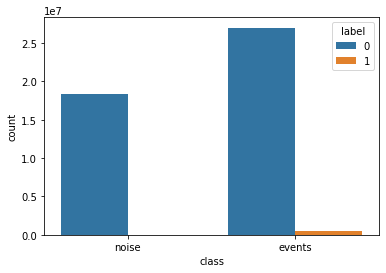

In [72]:
sns.countplot(x='class', hue='label', data=df_old)
plt.savefig("../../assets/class_imbalance.png", dpi=600, bbox_inches="tight")

In [73]:
sorted_mixed_df = sort_mixed_groups(df_mixed)
list_mixed_groups = sorted_mixed_df.group.unique()[:SIZE]
df_mixed = df_mixed[df_mixed.group.isin(list_mixed_groups)]
list_noise_groups = df_noise.groupby('group')['label'].count().sort_values(ascending=False)[:SIZE]
list_noise_groups = list(list_noise_groups.index)
df_noise = df_noise[df_noise.group.isin(list_noise_groups)]
df_noise['class'] = 'noise'
df_mixed['class'] = 'events'
df_new = pd.concat([df_noise, df_mixed])

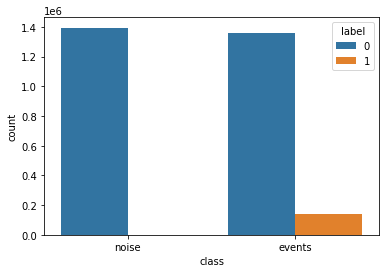

In [74]:
sns.countplot(x='class', hue='label', data=df_new)
plt.savefig("../../assets/class_imbalance_after_sampling.png", dpi=600, bbox_inches="tight")